<a href="https://colab.research.google.com/github/11harini04/Fast-Image-Encryption-algorithm-Based-on-Parallel-Computing-System/blob/main/Fast_image_encryption_algorithm_based_on_parallel_computing_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Input:** An image P with a size of m × n, where m denotes the rows of P, n denotes the columns of P. The group number p is determined according to
the available parallelism in the computing system.

**Output:** Cipher C.


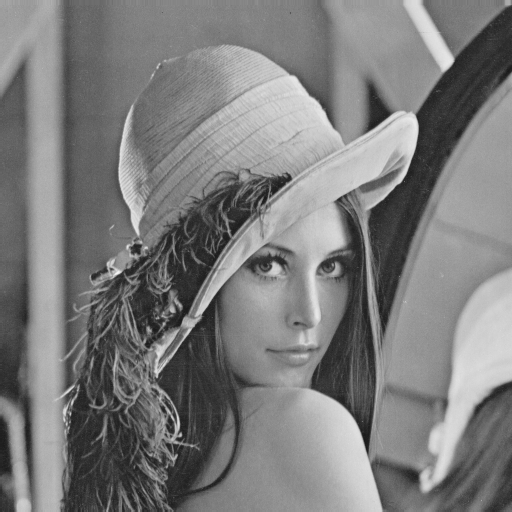

In [ ]:
from PIL import Image
import random
import threading
import numpy as np
from multiprocessing.pool import ThreadPool as Pool

pool_size = 4

# Open the image form working directory
image = Image.open('/content/lena_gray.gif').convert('L')
from numpy import asarray
data = asarray(image)
image

In [ ]:
def fn(x,mu):
    return (mu*x*(1-x))

Key generation using Coupled Map Logistic Lattices (CML) 

In [ ]:
def x_generation(K, m, n, p):
  #The secret key is divided into 12 subkeys
  k = [K[i:i+40] for i in range(12)]
  #print(k)

  #Calculating the mu and e  from the sub keys
  temp_sum = 0
  for i in range(40):
    temp_sum += int(k[0][i]) * pow(2,i)
  #when μ approaches 4 and e approaches 0, the chaos of CML is the strongest. μ ∈ [3.99, 4) and e ∈ [0, 0.1).
  mu = 3.99 + ( 0.01 * temp_sum / pow(2,40) )
  
  #e
  temp_sum = 0
  for i in range(40):
    temp_sum += int(k[1][i]) * pow(2,i)
  e = 0.1 * temp_sum / pow(2,40)
  #print(mu,e)
  
  #Here we have 10 lattices in total.
  #Initial values are calculated for each lattice
  x_0 = [0]*10
  for j in range(10): 
    for i in range(40):
      x_0[j] += int(k[j+2][i]) * pow(2,i)
    x_0[j] /= pow(2,40) 
  
  par = (2*p)+4
  L = 10
  x = [[0]*(201+max(m,n,par)) for i in range(10)] 
  for i in range(10):
      x[i][0] = x_0[i]

  #Run the iterations 201+max(m,n,par) times and find xi in every lattice
  for i in range(1,(201+max(m,n,par))):
      #print("Iter",i)
      for lattice in range(L):
          #print("\nLATTICE", lattice)
          if lattice == 0:
              x[lattice][i] = ((1-e)*fn(x[lattice][i-1], mu)) + ((e/2)*(fn(x[L-1][i-1], mu) + fn(x[lattice+1][i-1], mu)))
          elif lattice == L - 1:
              x[lattice][i] = ((1-e)*fn(x[lattice][i-1],mu)) + ((e/2)*(fn(x[lattice-1][i-1], mu) + fn(x[0][i-1], mu)))
          elif lattice > 0 and lattice < L - 1:
              x[lattice][i] = ((1-e)*fn(x[lattice][i-1], mu)) + ((e/2)*(fn(x[lattice-1][i-1], mu) + fn(x[lattice+1][i-1], mu)))
              
  return x



In [ ]:
#K - A 480 bit secret key used in encryption
K = ""
for i in range(480):
    K += str(random.randint(0, 1))
#print(K)

In [ ]:
# m - number of rows in P
# n - number of columns in P
m = data.shape[0]
n = data.shape[1]
print(m,n)
#parallelism available in computing system
p = 4        
par = 2*p + 4
x = x_generation(K, m, n, p)

512 512


In [ ]:
M = x[0][-m:]
N = x[1][-n:]
A = x[2][-par:]
B = x[3][-par:]
D = x[4][-par:]
E = x[5][-par:]

In [ ]:
import math
M = [math.floor(M[i]*pow(10,10)) for i in range(len(M))]
N = [math.floor(N[i]*pow(10,10)) for i in range(len(N))]

H = [M[i] % m for i in range(len(M))]
S = [N[i] % n for i in range(len(N))]

t = 5
b = 3
if (m>pow(10,t-1) and m<=pow(10,t)) and (n>0 and n<=pow(10,b)):
  M = [M[i]*pow(10,t) for i in range(len(M))]
  N = [N[i]*pow(10,b) for i in range(len(N))]

M = [(M[i]+i) for i in range(m)]
N = [(N[i]+i) for i in range(n)]

# **Encryption**

# Permutation

In [ ]:
import numpy as np
sortcolumn = data[:, np.argsort(N)]
cirshift_d = sortcolumn
for i in range(len(N)):
  cirshift_d[:,i] = np.roll(cirshift_d[:,i],S[i])
sortrows = cirshift_d[np.argsort(M),:]
cirshift_r = sortrows
for i in range(len(M)):
  cirshift_r[i,:] = np.roll(cirshift_r[i,:],H[i])
final = cirshift_r
print(final)

[[ 46 139  85 ... 174 132 154]
 [121  93 129 ... 208 124 154]
 [ 96  95 180 ... 205  69 136]
 ...
 [111 151 135 ... 140 112  80]
 [176 128  37 ... 127 124 102]
 [ 31  57 145 ... 112 105 198]]


# TIDBD Diffusion


Input : Permuted image, p, A, B, D,E

**Step 1:** Segment P1 into p groups, each with a length of t.


In [ ]:
import math 

final = final.reshape(1,m*n)
final1 = final[0]

#Fr is the list of 'p' groups
Fr = []

if ((m*n) % p== 0):
  t = m * n // p 
  for r in range(p):       
    Fr.append(final1[r*t:(r+1)*t])

else:
  t = math.floor( m* n / p) + 1
  T=np.zeros((t * p) -(m * n),np.uint8)
  final1 = np.append(final1,T)
  for r in range(p):          
    Fr.append(final1[r*t:(r+1)*t])

# print(t,len(Fr[0]))

In [ ]:
def diffuse(Fr, Ar, Br, Dr, Er):
  le = len(Fr)

  Gr = []
  Gr.append((Ar * pow(10,5)) % 256)  
  Gr.append((Br * pow(10,5)) % 256)   
  mu = 3.99 + 0.01 * Dr
  xi = Er
  for i in range(1,le+1):
    xi = mu * xi * (1 - xi)
    Gr.append((math.floor(Gr[i - 1] + pow(10,5) * Gr[i]/255 + xi * pow(10,5)) + Fr[i-1]) % 256)
  Gr = Gr[2:le+2]
  return Gr

**Step 2**
The *first independent diffusion* of each group is performed under the condition of parallelism.


Parallel diffusion based on multiprocessors

In [ ]:
pool = Pool(pool_size)

Gr_list = []
def worker1(r):
    #use rth keys
    return diffuse(Fr[r],A[r], B[r], D[r], E[r])

for r in range(p):
    x = pool.apply_async(worker1, (r,))
    Gr_list.append(x.get())

pool.close()
pool.join()

**Step 3**
Exchange the first two pixels with the last two pixels within each group

In [ ]:
for r in range(p):
  Gr_len = len(Gr_list[r])
  Gr_list[r][0], Gr_list[r][Gr_len-1] = Gr_list[r][Gr_len-1], Gr_list[r][0]
  Gr_list[r][1], Gr_list[r][Gr_len-2] = Gr_list[r][Gr_len-2], Gr_list[r][0]

**Step 4:**

Bidirectional diffusion of the first two pixels taken from all groups is performed. The diffusion process is also calculated in diffusion steps.


In [ ]:
GA1 = []
GA2 = []

for r in range(p):
  GA1.append(Gr_list[r][0])
  GA2.append(Gr_list[r][1])

GB1 = diffuse(GA1, A[p + 1], B[p + 1], D[p + 1], E[p + 1])
GB2 = diffuse(GA2, A[p + 3], B[p + 3], D[p + 3], E[p + 3])

GC1 = np.flip(GB1)
GC2 = np.flip(GB2)

GD1 = diffuse(GC1, A[p + 2], B[p + 2], D[p + 2], E[p + 2])
GD2 = diffuse(GC2, A[p + 4], B[p + 4], D[p + 4], E[p + 4])

for r in range(p):
  Gr_list[r][0] = GD1[r]
  Gr_list[r][1] = GD2[r]

**Step 5:**

The second independent diffusion of each group is performed under the condition of parallelism. 


Parallel diffusion based on multiprocessors

In [ ]:
pool = Pool(pool_size)

O = []
def worker2(r):
    return diffuse(Gr_list[r-p-4],A[r], B[r], D[r], E[r])

for r in range(p+4,2*p+4):
    x = pool.apply_async(worker2, (r,))
    O.append(x.get())

pool.close()
pool.join()

**Step 6:** Combine all the groups into the diffused image C.


In [ ]:
C = []
for i in range(p):
  C.append(O[i])

C = np.array(C)
if ((m*n) % p == 0):
  C = C.reshape(m,n)
else:
  C = C[0:m*n].reshape(m,n)

In [ ]:
C

array([[  9,  21, 226, ..., 253, 193, 175],
       [  2, 107,  47, ...,  99, 102, 175],
       [ 90,  36, 224, ...,  25, 232, 194],
       ...,
       [ 60, 248, 242, ..., 206, 134, 150],
       [ 73,  38, 191, ...,  43,  26, 202],
       [119, 242,  37, ..., 253,  41,  49]])

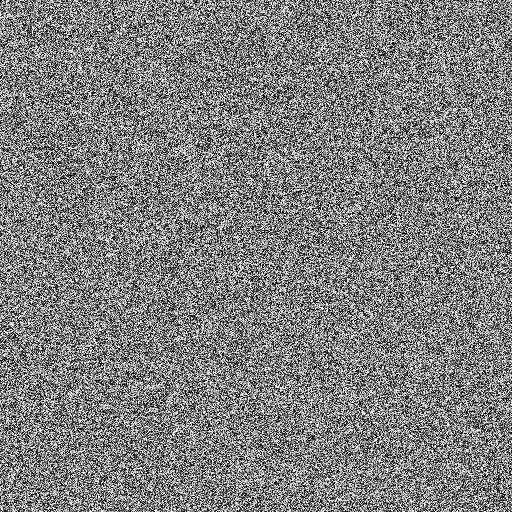

In [ ]:
encrypted_image = Image.fromarray(C.astype(np.uint8))
encrypted_image.save('encrypted_lena.gif')
encrypted_image

# **Decryption**

Reading Encrypted file

In [ ]:
from PIL import Image

# Open the image form working directory
image = Image.open('encrypted_lena.gif')
m = image.size[0]
n = image.size[1]
C = np.array(image)

In [ ]:
X = C
X

array([[  9,  21, 226, ..., 253, 193, 175],
       [  2, 107,  47, ...,  99, 102, 175],
       [ 90,  36, 224, ...,  25, 232, 194],
       ...,
       [ 60, 248, 242, ..., 206, 134, 150],
       [ 73,  38, 191, ...,  43,  26, 202],
       [119, 242,  37, ..., 253,  41,  49]], dtype=uint8)

# Decryption diffusion

In [ ]:
import math 
Ci = X.copy()
Ci = Ci.reshape(1,m*n)
C1 = Ci[0]

#O is the list of 'p' groups
O = []

if ((m*n) % p== 0):
  t = m * n // p
  for r in range(p):       
    O.append(C1[r*t:(r+1)*t])

else:
  t = math.floor( m* n / p) + 1
  T=np.zeros((t * p) -(m * n),np.uint8)
  C1 = np.append(C1,T)
  for r in range(p):          
    O.append(C1[r*t:(r+1)*t])

In [ ]:
def diffuse_decrypt(Gr, Ar, Br, Dr, Er):
  le = len(Gr)
  Fr = []
  Gr  = np.concatenate(([(Ar * pow(10,5)) % 256], Gr))
  Gr  = np.concatenate(([(Br * pow(10,5)) % 256], Gr))
  mu = 3.99 + 0.01 * Dr
  xi = Er
  for i in range(1,le+1):
    xi = mu * xi * (1 - xi)
    Fr.append((Gr[i + 1] - math.floor(Gr[i - 1] + pow(10,5) * Gr[i]/255 + xi * pow(10,5)))%256)
  return Fr

Parallel diffusion based on multiprocessors

In [ ]:
pool = Pool(pool_size)

Gr_list = []
def worker3(r):
    return diffuse_decrypt(O[r-p-4],A[r], B[r], D[r], E[r])

for r in range(p+4,2*p+4):
    x = pool.apply_async(worker3, (r,))
    Gr_list.append(x.get())

pool.close()
pool.join()

In [ ]:
for r in range(p):
  GD1[r] = Gr_list[r][0]
  GD2[r] = Gr_list[r][1]

GC1 = diffuse_decrypt(GD1, A[p + 2], B[p + 2], D[p + 2], E[p + 2])
GC2 = diffuse_decrypt(GD2, A[p + 4], B[p + 4], D[p + 4], E[p + 4])

GB1 = np.flip(GC1)
GB2 = np.flip(GC2)

GA1 = diffuse_decrypt(GB1, A[p + 1], B[p + 1], D[p + 1], E[p + 1])
GA2 = diffuse_decrypt(GB2, A[p + 3], B[p + 3], D[p + 3], E[p + 3])

for r in range(p):
  Gr_list[r][0] = GA1[r]
  Gr_list[r][1] = GA2[r]


In [ ]:
for r in range(p):
  Gr_len = len(Gr_list[r])
  Gr_list[r][0], Gr_list[r][Gr_len-1] = Gr_list[r][Gr_len-1], Gr_list[r][0]
  Gr_list[r][1], Gr_list[r][Gr_len-2] = Gr_list[r][Gr_len-2], Gr_list[r][0]

Parallel diffusion based on multiprocessors

In [ ]:
pool = Pool(pool_size)

Fr = []
def worker4(r):
    return diffuse_decrypt(Gr_list[r],A[r], B[r], D[r], E[r])

for r in range(p):
    x = pool.apply_async(worker4, (r,))
    Fr.append(x.get())

pool.close()
pool.join()

In [ ]:
P = []
for i in range(p):
  P.append(Fr[i])

P = np.array(P)
if ((m*n) % p == 0):
  P = P.reshape(m,n)
else:
  P = P[0:m*n].reshape(m,n)

In [ ]:
P

array([[173., 171., 230., ..., 174., 132., 154.],
       [121.,  93., 129., ..., 208., 124., 154.],
       [ 96.,  95., 180., ..., 205.,  69., 136.],
       ...,
       [111., 151., 135., ..., 140., 112.,  80.],
       [176., 128.,  37., ..., 127., 124., 102.],
       [ 31.,  57., 145., ..., 112., 110., 115.]])

# Decryption permutation

In [ ]:
cirshift_l = P.copy()
for i in range(len(M)):
  cirshift_l[i,:] = np.roll(cirshift_l[i,:],-H[i])
sortrows = cirshift_l

M_rev = np.zeros_like(M)
M_rev[np.argsort(M)] = np.arange(len(M))
cirshift_u = sortrows[M_rev,:]
for i in range(len(N)):
  cirshift_u[:,i] = np.roll(cirshift_u[:,i],-S[i])
sortcolumn = cirshift_u
N_rev = np.zeros_like(N)
N_rev[np.argsort(N)] = np.arange(len(N))
X = sortcolumn[:, N_rev]
X

array([[162., 162., 162., ..., 170., 155., 128.],
       [162., 162., 162., ..., 170., 155., 128.],
       [162., 162., 162., ..., 170., 155., 128.],
       ...,
       [ 43.,  43.,  50., ..., 104., 100.,  98.],
       [ 44.,  44.,  55., ..., 104., 105., 108.],
       [ 44.,  44.,  55., ..., 104., 105., 108.]])

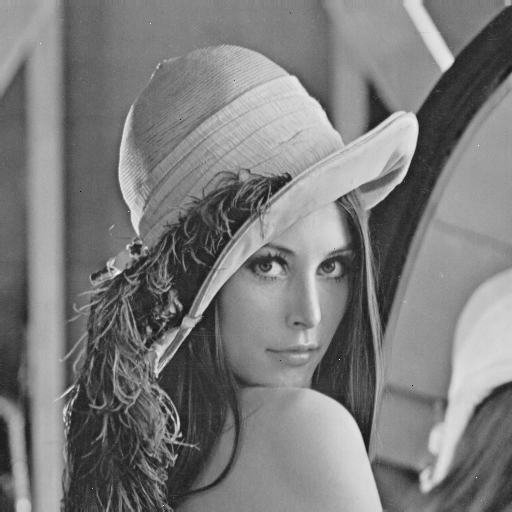

In [ ]:
img = Image.fromarray(X.astype(np.uint8))
img

# **Encryption Performance Analysis**

# Adjacent pixel correlation

Original image

In [ ]:
from scipy.stats import pearsonr
X = []
Y_ver = []
Y_hor = []
Y_diag = []
for i in range(len(data)):
  for j in range(len(data)):
    if (i!=0 and i!=len(data)-1 and j!=0 and j!=len(data)-1):
      X.append(data[i][j])
      Y_ver.append(data[i-1][j])
      Y_hor.append(data[i][j-1])

print("Vertical pixel Correlation: ",pearsonr(X,Y_ver)[0])
print("Horizontal pixel Correlation:" ,pearsonr(X,Y_hor)[0])

Vertical pixel Correlation:  0.9849123622078297
Horizontal pixel Correlation: 0.9718235385174856


Encrypted image

In [ ]:
from scipy.stats import pearsonr
image = Image.open('encrypted_lena.gif')
m = image.size[0]
n = image.size[1]
enc = np.array(image)
X = []
Y_ver = []
Y_hor = []
Y_diag = []
for i in range(len(enc)):
  for j in range(len(enc)):
    if (i!=0 and i!=len(enc)-1 and j!=0 and j!=len(enc)-1):
      X.append(enc[i][j])
      Y_ver.append(enc[i-1][j])
      Y_hor.append(enc[i][j-1])

print("Vertical pixel Correlation: ",pearsonr(X,Y_ver)[0])
print("Horizontal pixel Correlation:",pearsonr(X,Y_hor)[0])

Vertical pixel Correlation:  0.0007160825086972938
Horizontal pixel Correlation: 0.0025711535127015857


# Pixel Distribution

Pixel distribution Histogram of Original Image

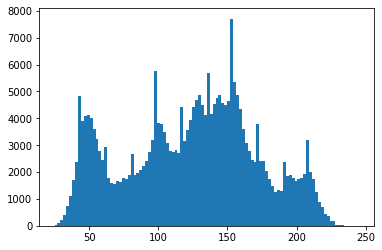

In [ ]:
import matplotlib.pyplot as plt
plt.hist(data.ravel(),bins = 'auto')
plt.show()

Pixel distribution Histogram of Encrypted image

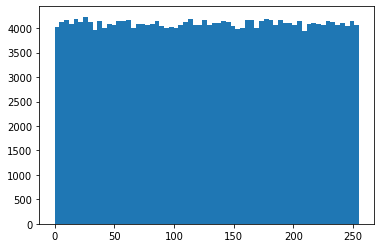

In [ ]:
plt.hist(enc.ravel(),bins = 'auto')
plt.show()